In [50]:
%matplotlib inline

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


Model Summary: 314 layers, 36481772 parameters, 6194944 gradients, 103.2 GFLOPS


IDetect.fuse


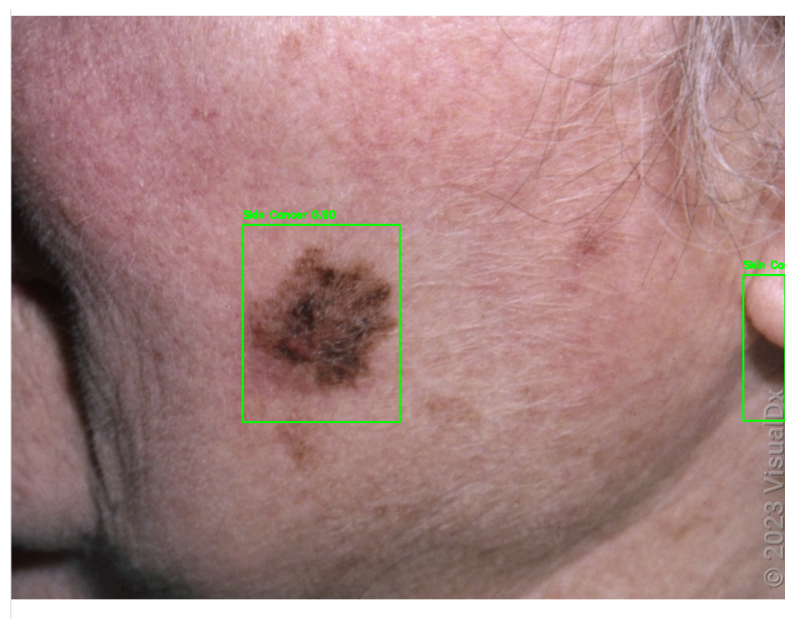

Image saved at C:\MSAAI\AAI-521\Final Project Data\image_with_bounding_box.png


In [55]:
# Import necessary libraries
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from torchvision.transforms import functional as F
from pathlib import Path
from models.experimental import attempt_load
from utils.general import non_max_suppression, scale_coords

# Define helper functions
def preprocess_image(image_path, img_size=640):
    """
    Preprocess the image for YOLOv7 input.
    """
    img = cv2.imread(image_path)  # Read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (img_size, img_size))  # Resize to 640x640 (YOLO input size)
    img = img / 255.0  # Normalize to 0-1
    img = np.transpose(img, (2, 0, 1))  # Change shape to (C, H, W)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = torch.from_numpy(img).float()  # Convert to torch tensor
    return img

def draw_bounding_boxes(image, detections):
    """
    Draw bounding boxes on the original image.
    """
    for *xyxy, conf, cls in detections:
        x1, y1, x2, y2 = map(int, xyxy)  # Get coordinates
        label = f"Skin Cancer {conf:.2f}"  # Add confidence to label
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw bounding box
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)  # Add label text
    return image

# Load the YOLOv7 model
weights_path = r"C:\MSAAI\AAI-521\Final Project Data\YOLO Model Data\best.pt"  # Path to your trained weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Attempt to load the YOLO model
model = attempt_load(weights_path, map_location=device)
model.to(device)
model.eval()  # Set to evaluation mode

# Load and preprocess the image
image_path = r"C:\MSAAI\AAI-521\Final Project Data\image_for_model_showcase.png"
original_image = cv2.imread(image_path)  # Read the original image
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert to RGB
showcase_image = preprocess_image(image_path).to(device)  # Preprocess and move to device

# Run inference
with torch.no_grad():  # Disable gradient calculation for inference
    pred = model(showcase_image)[0]  # Get raw predictions

# Apply non-maximum suppression (NMS)
detections = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45)[0]

if detections is not None:
    # Scale coordinates back to the original image size
    detections[:, :4] = scale_coords(showcase_image.shape[2:], detections[:, :4], original_image.shape[:2]).round()

    # Draw bounding boxes on the original image
    bound_image = draw_bounding_boxes(original_image_rgb, detections)

    # Display the result
    plt.figure(figsize=(10, 10))
    plt.imshow(bound_image)
    plt.axis("off")
    plt.show()

    # Save the image with bounding boxes
    output_path = r"C:\MSAAI\AAI-521\Final Project Data\image_with_bounding_box.png"
    cv2.imwrite(output_path, cv2.cvtColor(bound_image, cv2.COLOR_RGB2BGR))  # Convert back to BGR before saving
    print(f"Image saved at {output_path}")
else:
    print("No detections found.")
